# Damped Local Trend (DLT)

Here we will cover:

- DLT model structure
- DLT global trend configurations
- Adding regressors in DLT
- Other configurations

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.dataset import load_iclaims

## Model Structure

**DLT** is one of the main exponential smoothing models we support in `orbit`.  Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset [(Ng and Wang et al.)](https://arxiv.org/abs/2004.08492).  The model is a fusion between the classical ETS [(Hyndman et. al, 2008)](http://www.exponentialsmoothing.net/home)) with some refinement leveraging ideas from Rlgt [(Smyl et al. 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html,). The model has a structural forecast equations as such

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$\hat{y}_t=\mu_t + s_t + r_t $$
$$\mu_t=g_t + l_{t-1} +  \theta{b_{t-1}}$$

with the update process as such 

$$
\begin{align*}
g_t & =  D(t) \\
l_t & =  \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)(l_{t-1} + \theta b_{t-1}) \\
b_t & =   \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta{b_{t-1}} \\
s_{t+m} & =  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t \\
r_t & =   \Sigma_{j}\beta_j x_{jt}
\end{align*}
$$

One important point is here that using $y_t$ as a log-transformed response usually yield better result, especially we can interpret such log-transformed model as a *multiplicative form* of the original model.  Besides, there are two new additional components compared to the classical damped ETS model:
1. $D(t)$ as the deterministic trend process
2. $r_t$ as the regression component with $x_t$ as the regressors

In [67]:
# load log-transformed data
df = load_iclaims()
test_size = 52 * 
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Global Trend Configurations

There are a few choices of $D(t)$ configured by `global_trend_option`:
1. `loglinear`
2. `linear`
3. `flat`
4. `logistic`    

To show the difference among these options. We project the predictions in the charts below. Note that the default is set to `linear` which we find a better fit for a log-transformed model.  Such default is also used in the benchmarking process mentioned previously.

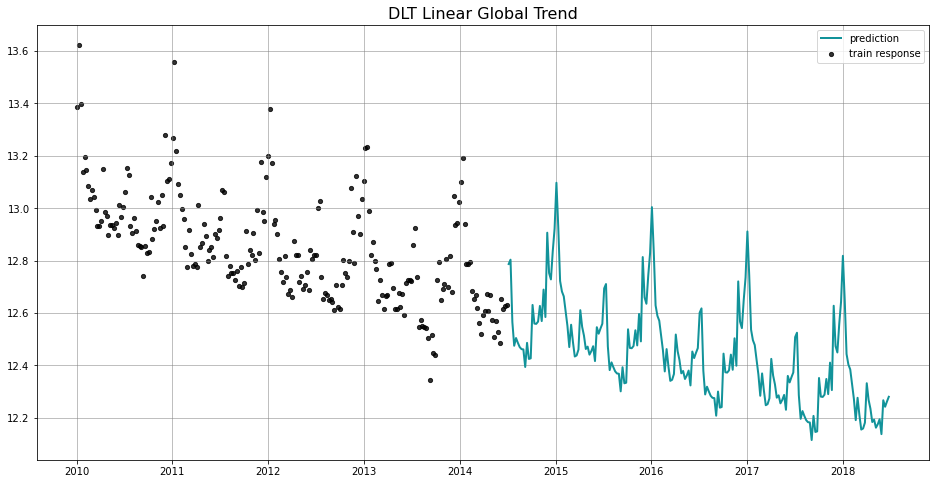

CPU times: user 467 ms, sys: 41.3 ms, total: 508 ms
Wall time: 343 ms


In [68]:
%%time
# linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

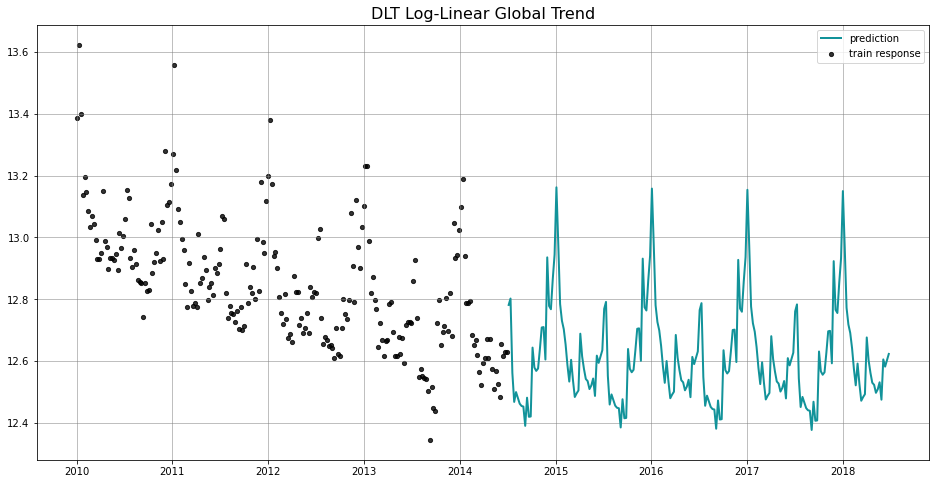

CPU times: user 513 ms, sys: 44.4 ms, total: 558 ms
Wall time: 396 ms


In [69]:
%%time
# log-linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='loglinear'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Log-Linear Global Trend')

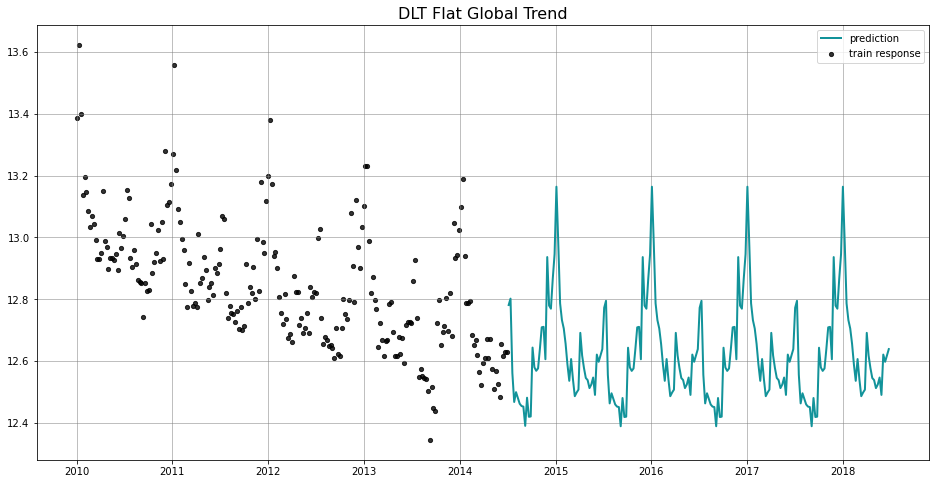

CPU times: user 454 ms, sys: 44.6 ms, total: 499 ms
Wall time: 335 ms


In [70]:
%%time
# log-linear global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='flat'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Flat Global Trend')

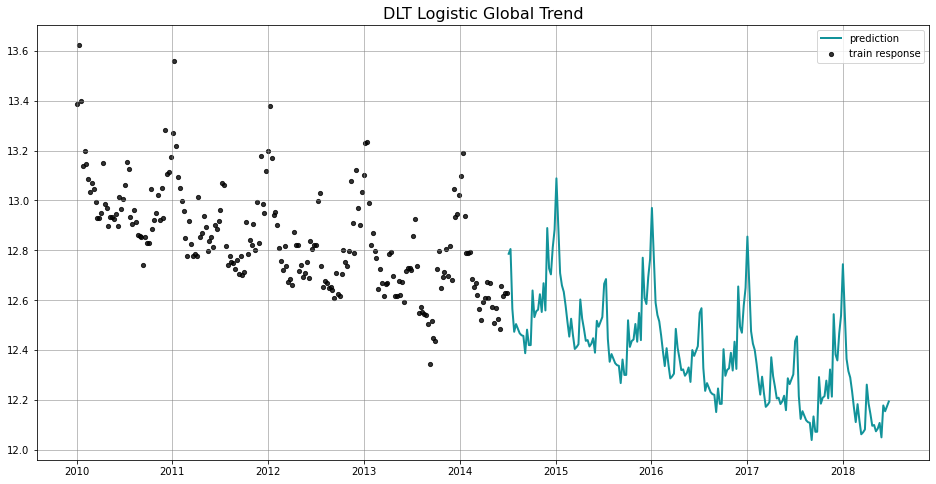

CPU times: user 525 ms, sys: 44.4 ms, total: 569 ms
Wall time: 422 ms


In [72]:
%%time
# logistic global trend
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='logistic'
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col,  title='DLT Logistic Global Trend')

## DLT Model with Global Trend

The main differences between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

## Regression

In orbit, we have three different wrappers for DLT models, `DLTMAP`, `DLTAggregated` and  `DLTFull`

Another feature of DLT is the regression
component $r_t$. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, assume

$$\beta_j ~\sim \mathtt{Normal}(\mu_j, \sigma_j^2)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. There are more choices of priors for the regression component in the package.

More details for each method are available in the docstrings and also here: https://uber.github.io/orbit/orbit.models.html#module-orbit.models.dlt